# Modeling Performance

|  Model                |  Out Of Box AUC  |  Tuned AUC  |
|-----------------------|------------------|-------------|
|  CatBoost             |  0.8572          |  0.     |

In [1]:
# General
import pandas as pd
import numpy as np
from time import time
from pprint import PrettyPrinter
import pickle

# Data Tools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Models
from catboost import CatBoostClassifier

# Plotting Tools
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
pp = PrettyPrinter()

In [17]:
df = pd.read_csv('../data/telco_churn_clean.csv')

In [18]:
# Get rid of IDs
df.drop('customerID', axis=1, inplace=True)

# Turn the target into integers and seperate
df['Churn'] = df['Churn'].replace('Yes', 1)
df['Churn'] = df['Churn'].replace('No', 0)
target = df['Churn']
df.drop('Churn', axis=1, inplace=True)

# Standardize Numerics
scaler = StandardScaler()
numer_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
numerics = df[numer_cols]
numerics = pd.DataFrame(scaler.fit_transform(numerics), columns=numer_cols)
for col in numerics:
    df[col] = numerics[col]

# Get columns which have 4 or less unique vals in them, aka the categoricals in this dataset
cat_cols = df.nunique()[df.nunique() <= 4].index.tolist()
# Get column indices (catboost only accepts a list of integers - not strings)
cat_cols = [df.columns.get_loc(col) for col in cat_cols]

# Train Test Split
train_x, test_x, train_y, test_y = train_test_split(df, target, random_state=42)

## Main Modeling Function

In [19]:
def grid_classifier(model, train, target, parameters={}, cv=5, timed=True, feat_imp=False, verbose=True):
    '''
    For tuning models.
    
    Automatically plots CV results, but this requires training over on parameter at a time.
    If the parameters argument stays an empty dictionary then no plot is made (duh...)
    
    Returns the GridSearch object
    
        Parameters:
        -----------
    model - model
    train - array of training data
    target - array of target data
    parameters - dict of parameters the GSearcher will run over
    cv - int, k-fold number
    timed - boolean, gives printout of timings
    
        Returns :
        ---------
    gsearcher - fitted and searched GridSearchCV object
    '''
    if timed:
        start = time()
    
    # Grid Search
    gsearcher = GridSearchCV(
        estimator=model, 
        param_grid=parameters,
        scoring='roc_auc',
        n_jobs=-1,
        cv=cv,
        return_train_score=True
    )
    gsearcher.fit(train, target)
    results = gsearcher.cv_results_
    
    if timed:
        passed = time() - start
        print(f'Seconds to fit: {passed:.2f}')

    if verbose:
        # Print Report
        print('Grid Scores: \n')
        pp.pprint(results)
        print(f'Best Model Parameters: {gsearcher.best_params_}')
        print(f'Best Model Score: {gsearcher.best_score_:.4f}')
    else:
        score = np.mean(results['mean_test_score'])
        print(f'AUC: {round(score, 4)}')
    
    # Plot CV Results
    if parameters:
        test_means = results['mean_test_score']
        train_means = results['mean_train_score']
        x = range(len(test_means))
        model_name = str(model.__class__).split('.')[-1][:-2]
        param = list(results['params'][0].keys())[0]
        labels = [str(pair[param]) for pair in results['params']]

        plt.figure(figsize=(10, 8))
        plt.plot(x, test_means, label='Test', color='blue')
        plt.plot(x, train_means, label='Train', color='green')
        plt.title(f'{model_name} over {param}')
        plt.xlabel(param)
        plt.ylabel('AUC Scores')
        plt.xticks(x, labels, rotation=60)
        plt.legend()
    
    # Plot Feature Importance
    if feat_imp:
        best_model = gsearcher.best_estimator_
        best_model.fit(train, target)
        feat_series = pd.Series(best_model.feature_importances_, index=train.columns)
        feat_series.sort_values(ascending=False, inplace=True)

        plt.figure(figsize=(10, 8))
        feat_series.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.xticks(rotation=60)        
    
    return gsearcher

## Modeling

## Table of Contents
* Baseline
* Loss Function
* N Estimators
* Max Depth
* L2 Leaf Reg
* Border Count
* Ctr Border Count
* Learning Rate
* Final Model

### Baseline

In [20]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False
)

baseline_gsearch = grid_classifier(model, test_x, test_y, verbose=False)

Seconds to fit: 279.65
AUC: 0.8572


In [21]:
baseline_gsearch.best_estimator_.tree_count_

1000

In [22]:
baseline_lr = baseline_gsearch.best_estimator_.learning_rate_
baseline_lr

0.01966400072

In [23]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=750,
    learning_rate=baseline_lr*(4/3)
)

grid_classifier(model, test_x, test_y, verbose=False)

KeyboardInterrupt: 

#### Loss Function
Stickng with the default of 'Logloss'

In [10]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
)

grid_classifier(model, train_x, train_y, verbose=False)

Seconds to fit: 313.96
AUC: 0.8456


GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x10ce060f0>,
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [9]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    loss_function='CrossEntropy'
)

grid_classifier(model, train_x, train_y, verbose=False)

Seconds to fit: 348.57
AUC: 0.8456


GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x10ce06c88>,
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [8]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    loss_function='MultiClass'
)

grid_classifier(model, train_x, train_y, verbose=False)

Seconds to fit: 208.95
AUC: 0.8455


GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x10ce06be0>,
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

#### N Estimators & Learning Rate
It keeps going up, I'm cutting it here with a value of 350

In [24]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=1000,
    learning_rate=baseline_lr
)

grid_classifier(model, train_x, train_y, verbose=False)

Seconds to fit: 320.85
AUC: 0.8472


GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x1a1bd8f5f8>,
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [25]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=750,
    learning_rate=baseline_lr*(4/3)
)

grid_classifier(model, train_x, train_y, verbose=False)

Seconds to fit: 225.10
AUC: 0.8465


GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x1a1bd59358>,
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [26]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=500,
    learning_rate=baseline_lr*2
)

grid_classifier(model, train_x, train_y, verbose=False)

Seconds to fit: 166.82
AUC: 0.8462


GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x1a1bd72828>,
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [27]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=333,
    learning_rate=baseline_lr*3
)

grid_classifier(model, train_x, train_y, verbose=False)

Seconds to fit: 102.60
AUC: 0.8453


GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x1a1bd590f0>,
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Seconds to fit: 914.24
Grid Scores: 

{'mean_fit_time': array([ 5.81621718, 10.37933064, 15.27080383, 20.60542221, 25.82912545,
       31.01070752, 39.5215416 , 42.29365401, 46.50317936, 51.94758453,
       57.29432197, 62.86243434, 69.55804377, 79.44094453, 79.69708948,
       74.51419506]),
 'mean_score_time': array([0.02014079, 0.01460681, 0.01492963, 0.01511197, 0.01559091,
       0.01545601, 0.0158144 , 0.01583257, 0.01620412, 0.01647601,
       0.01675668, 0.01642203, 0.01670051, 0.01944461, 0.01684065,
       0.0154274 ]),
 'mean_test_score': array([0.84318254, 0.84535315, 0.84437456, 0.84431656, 0.84468181,
       0.84606937, 0.84587927, 0.8454946 , 0.84566133, 0.84631657,
       0.84578849, 0.84580509, 0.8456969 , 0.84703539, 0.84589246,
       0.84604553]),
 'mean_train_score': array([0.85721967, 0.86241833, 0.86515094, 0.86689185, 0.865568  ,
       0.8649953 , 0.86614386, 0.86767184, 0.86701544, 0.86681356,
       0.86722738, 0.86755547, 0.86683348, 0.8670556 , 0.86880189,


GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x1a26bfbd68>,
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': range(25, 401, 25)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

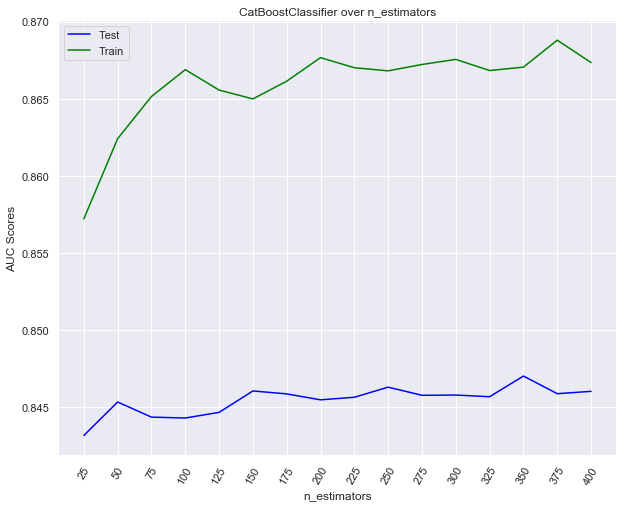

In [53]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False
)

parameters = {'n_estimators': range(25, 401, 25)}

grid_classifier(model, train_x, train_y, parameters)

#### Max Depth
Could pick default of None or 6 which has same AUC, going with 6

In [15]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=350,
    max_depth=None
)

grid_classifier(model, train_x, train_y, verbose=False)

Seconds to fit: 118.51
AUC: 0.847


GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x1a209f6d30>,
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Seconds to fit: 960.09
Grid Scores: 

{'mean_fit_time': array([ 59.46849861,  62.50300441,  66.35069251,  73.67418637,
        77.92421122,  93.73927469, 128.78539391, 183.11256032]),
 'mean_score_time': array([0.01749558, 0.01587014, 0.01597152, 0.0167417 , 0.01678014,
       0.01724129, 0.01889386, 0.01672239]),
 'mean_test_score': array([0.84633045, 0.84609694, 0.84612068, 0.84703539, 0.84563523,
       0.8457848 , 0.84661834, 0.84522096]),
 'mean_train_score': array([0.8571316 , 0.86097806, 0.86408665, 0.8670556 , 0.87084917,
       0.87361388, 0.8752323 , 0.87723577]),
 'param_max_depth': masked_array(data=[3, 4, 5, 6, 7, 8, 9, 10],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'max_depth': 3},
            {'max_depth': 4},
            {'max_depth': 5},
            {'max_depth': 6},
            {'max_depth': 7},
            {'max_depth': 8},
            {'max_depth': 9},
            {'max_

GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x1a25652dd8>,
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(3, 11)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

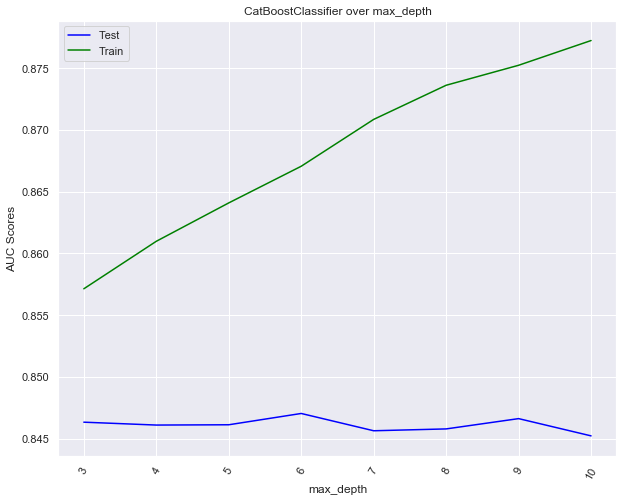

In [55]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=350
)

parameters = {'max_depth': range(3, 11)}

grid_classifier(model, train_x, train_y, parameters)

#### L2 Leaf Reg
Sticking with default of None

In [13]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=350,
    max_depth=6,
    l2_leaf_reg=None
)

grid_classifier(model, train_x, train_y, verbose=False)

Seconds to fit: 112.46
AUC: 0.847


GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x10ce06978>,
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Seconds to fit: 855.64
Grid Scores: 

{'mean_fit_time': array([70.55816584, 67.65628633, 67.80178008, 67.00847979, 67.4133625 ,
       67.36655269, 67.83452682, 67.64256849, 67.383359  , 53.39364891]),
 'mean_score_time': array([0.01770802, 0.01634636, 0.01643786, 0.0162962 , 0.01629567,
       0.01613913, 0.01599712, 0.01613216, 0.01591482, 0.01473842]),
 'mean_test_score': array([0.84672439, 0.84624971, 0.84627113, 0.84659161, 0.84614564,
       0.84629565, 0.84626835, 0.84647394, 0.84607833, 0.8466891 ]),
 'mean_train_score': array([0.85714608, 0.857167  , 0.85711715, 0.85701348, 0.8567886 ,
       0.85681637, 0.85691451, 0.85693236, 0.85724868, 0.85692935]),
 'param_l2_leaf_reg': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object),
 'params': [{'l2_leaf_reg': 1},
            {'l2_leaf_reg': 2},
            {'l2_leaf_reg': 3},
 

GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x1a24cf1ba8>,
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'l2_leaf_reg': range(1, 11)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

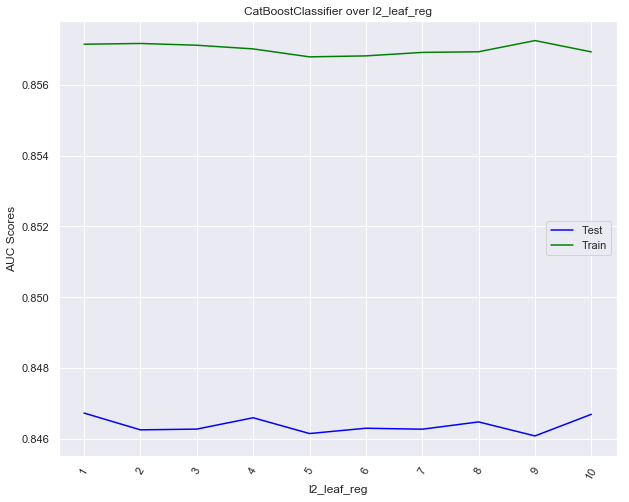

In [56]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=350,
    max_depth=6
)

parameters = {'l2_leaf_reg': range(1, 11)}

grid_classifier(model, train_x, train_y, parameters)

#### Border Count
Border count for numericals

Sticking with none here

In [19]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=350,
    max_depth=6,
    border_count=None,
)

grid_classifier(model, train_x, train_y, verbose=False)

Seconds to fit: 107.80
AUC: 0.847


GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x1a209bfbe0>,
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Seconds to fit: 700.38
Grid Scores: 

{'mean_fit_time': array([86.67185926, 75.07619591, 77.12745538, 81.80800586, 76.86940141,
       78.11000695, 64.29578691]),
 'mean_score_time': array([0.02218332, 0.01840138, 0.01838717, 0.01862836, 0.0179738 ,
       0.01709414, 0.01712704]),
 'mean_test_score': array([0.84382642, 0.845286  , 0.84544172, 0.84595249, 0.84667769,
       0.84699328, 0.8447989 ]),
 'mean_train_score': array([0.85901335, 0.86211075, 0.86350578, 0.86619103, 0.86672188,
       0.8675908 , 0.86791388]),
 'param_border_count': masked_array(data=[8, 16, 32, 64, 128, 200, 250],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'border_count': 8},
            {'border_count': 16},
            {'border_count': 32},
            {'border_count': 64},
            {'border_count': 128},
            {'border_count': 200},
            {'border_count': 250}],
 'rank_test_score': array([7, 5, 4, 3, 2, 1

GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x1a20c304e0>,
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'border_count': [8, 16, 32, 64, 128, 200, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

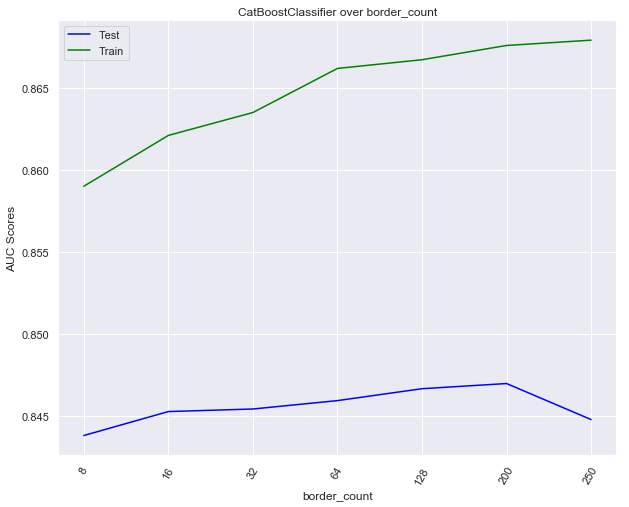

In [23]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=350,
    max_depth=6,
)

parameters = {'border_count': [2**i for i in range(3, 8)] + [200, 250]}

grid_classifier(model, train_x, train_y, parameters)

#### Learning Rate
Default is None which means it determines what it should be. Allowing it to stick with 0.068377

In [40]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=350,
    max_depth=6,
    border_count=None,
    learning_rate=None
)

gsearch = grid_classifier(model, train_x, train_y, verbose=False)

Seconds to fit: 123.04
AUC: 0.847


In [45]:
gsearch.best_estimator_.learning_rate_

0.06837700307

In [46]:
learning_rate = 0.068377
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=175,
    max_depth=6,
    border_count=None,
    learning_rate=learning_rate*2
)

grid_classifier(model, train_x, train_y, verbose=False)

Seconds to fit: 58.40
AUC: 0.8453


GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x1a20d28a20>,
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [47]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=700,
    max_depth=6,
    border_count=None,
    learning_rate=learning_rate/2
)

grid_classifier(model, train_x, train_y, verbose=False)

Seconds to fit: 237.68
AUC: 0.8463


GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x1a20d28e48>,
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [48]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=1400,
    max_depth=6,
    border_count=None,
    learning_rate=learning_rate/4
)

grid_classifier(model, train_x, train_y, verbose=False)

Seconds to fit: 436.26
AUC: 0.8458


GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x1a209f6978>,
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

#### Final CatBoost Model

In [49]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=350,
    max_depth=6,
)

gsearch = grid_classifier(model, test_x, test_y, verbose=False)

Seconds to fit: 92.92
AUC: 0.8572


Hahahahahahaha no increase in AUC. At the very least it trains faster than the base of 1000 trees.